# Introduction


## Overview of Time Series Forecasting
Time series forecasting involves predicting future values based on past observations, where the data points are collected sequentially over time. This branch of data analysis is essential in various domains such as finance, weather forecasting, inventory management, and more. The key challenge in time series forecasting lies in capturing and exploiting the temporal dependencies present in the data to make accurate predictions.

## Importance of LSTM for Time Series Data
Long Short-Term Memory (LSTM) networks, a type of recurrent neural network (RNN), have proven to be highly effective for modeling time series data. Unlike traditional feedforward neural networks, LSTM networks are designed to process sequences of data where inputs can have complex temporal dependencies. This capability makes LSTMs suitable for tasks like predicting stock prices, weather patterns, and even natural language processing tasks that involve sequences of words or characters.


## Objective of the Notebook
The objective of this notebook is to explore the application of LSTM networks for temperature forecasting using historical weather data collected in Delhi from 2013 to 2017. We aim to demonstrate how to preprocess time series data and create LSTM models for both univariate and multivariate forecasting.

# Data Collection and Preparation

## Load the dataset
The weather dataset used in this notebook consists of two CSV files: DailyDelhiClimateTrain.csv and DailyDelhiClimateTest.csv. These files contain daily climate data collected in Delhi over multiple years. We are going to concatenate the two dataset for preparation and split it again later.
Let's begin by loading and inspecting the dataset.

In [28]:
import os
# Download the dataset
if not os.path.exists('daily-climate-time-series-data.zip'):
  try:
    !kaggle datasets download -d sumanthvrao/daily-climate-time-series-data
  except:
    %pip install kaggle
    !kaggle datasets download -d sumanthvrao/daily-climate-time-series-data
# if the DailyDelhiClimateTrain.csv and DailyDelhiClimateTest.csv files are here, remove them
if os.path.exists('DailyDelhiClimateTrain.csv'):
  os.remove('DailyDelhiClimateTrain.csv')
if os.path.exists('DailyDelhiClimateTest.csv'):
  os.remove('DailyDelhiClimateTest.csv')
# Unzip
!unzip daily-climate-time-series-data.zip

Archive:  daily-climate-time-series-data.zip
  inflating: DailyDelhiClimateTest.csv  
  inflating: DailyDelhiClimateTrain.csv  


In [29]:
import pandas as pd

# Load the datasets
train_data = pd.read_csv('DailyDelhiClimateTrain.csv', parse_dates=['date'])
train_data.set_index('date', inplace=True)
test_data = pd.read_csv('DailyDelhiClimateTest.csv', parse_dates=['date'])
test_data.set_index('date', inplace=True)

# Print datasets info
print("Train Data:")
print(train_data)
print("\nTest Data:")
print(test_data)

Train Data:
             meantemp    humidity  wind_speed  meanpressure
date                                                       
2013-01-01  10.000000   84.500000    0.000000   1015.666667
2013-01-02   7.400000   92.000000    2.980000   1017.800000
2013-01-03   7.166667   87.000000    4.633333   1018.666667
2013-01-04   8.666667   71.333333    1.233333   1017.166667
2013-01-05   6.000000   86.833333    3.700000   1016.500000
...               ...         ...         ...           ...
2016-12-28  17.217391   68.043478    3.547826   1015.565217
2016-12-29  15.238095   87.857143    6.000000   1016.904762
2016-12-30  14.095238   89.666667    6.266667   1017.904762
2016-12-31  15.052632   87.000000    7.325000   1016.100000
2017-01-01  10.000000  100.000000    0.000000   1016.000000

[1462 rows x 4 columns]

Test Data:
             meantemp   humidity  wind_speed  meanpressure
date                                                      
2017-01-01  15.913043  85.869565    2.743478     59.0

In [30]:
# Merge the datasets
train_data = train_data.iloc[:-1] # Remove the last row of the first dataset to not overlap with the first row of the second dataset
data = pd.concat([train_data, test_data])
print("Concatenated data:")
print(data)

Concatenated data:
             meantemp   humidity  wind_speed  meanpressure
date                                                      
2013-01-01  10.000000  84.500000    0.000000   1015.666667
2013-01-02   7.400000  92.000000    2.980000   1017.800000
2013-01-03   7.166667  87.000000    4.633333   1018.666667
2013-01-04   8.666667  71.333333    1.233333   1017.166667
2013-01-05   6.000000  86.833333    3.700000   1016.500000
...               ...        ...         ...           ...
2017-04-20  34.500000  27.500000    5.562500    998.625000
2017-04-21  34.250000  39.375000    6.962500    999.875000
2017-04-22  32.900000  40.900000    8.890000   1001.600000
2017-04-23  32.875000  27.500000    9.962500   1002.125000
2017-04-24  32.000000  27.142857   12.157143   1004.142857

[1575 rows x 4 columns]


We'll plot the mean temperature, humidity, wind speed, and mean pressure over time to gain insights into their distributions and patterns.

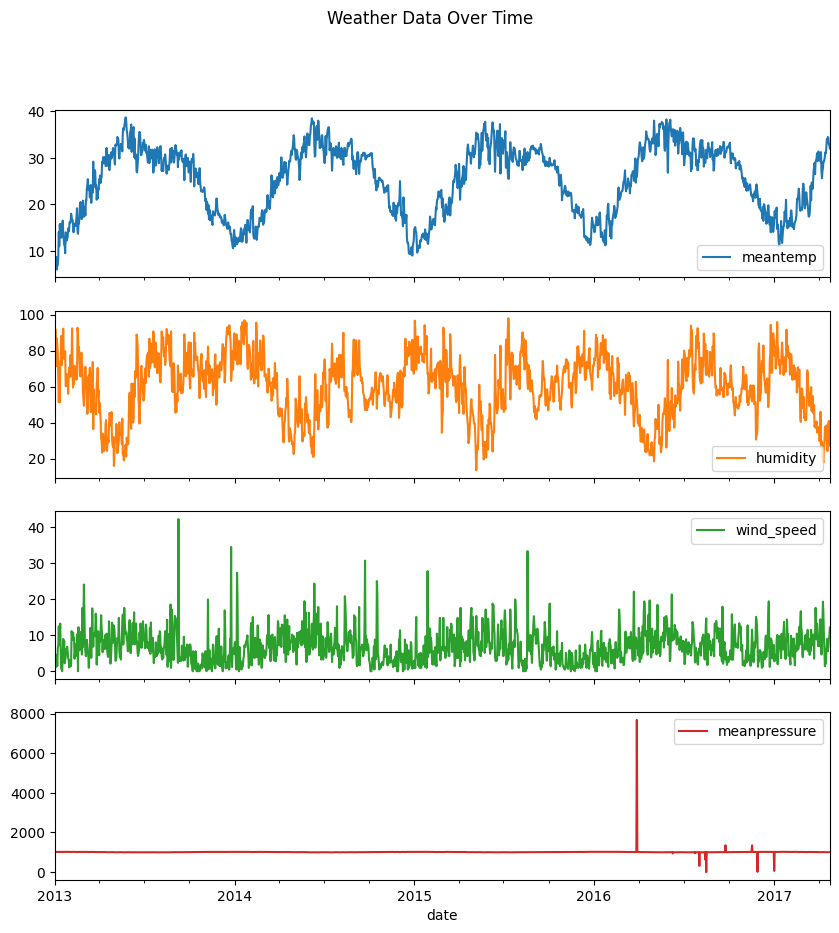

In [31]:
import matplotlib.pyplot as plt

# Plotting all the data
data.plot(subplots=True, figsize=(10, 10))
plt.suptitle('Weather Data Over Time')
plt.show()



The data appears consistent with what was expected for temperature, humidity and wind speed but for pressure the graph looks like a flat line with a few outliers. This observation can be confirmed by printing the summary statistics

In [32]:
# Summary statistics
print("Summary Statistics:")
data.describe()

Summary Statistics:


,meantemp,humidity,wind_speed,meanpressure
count,1575.000000,1575.000000,1575.000000,1575.000000
mean,25.231582,60.420115,6.903642,1010.589745
std,7.337316,16.956083,4.508803,175.298310
min,6.000000,13.428571,0.000000,-3.041667
25%,18.516667,49.750000,3.700000,1001.875000
50%,27.166667,62.380952,6.370000,1009.000000
75%,31.142857,72.125000,9.262500,1015.183333
max,38.714286,98.000000,42.220000,7679.333333


## Handle outliers

As we can see, for the pressure, we have a negative minimum value and a maximum value around 7600hPa which shouldn't be possible. Before going further, we are going to remove these outliers using the Hampel filter. This filter relies on the Median Absolute Deviation (MAD) and employs a rolling window for the identification of outliers.

In [33]:
# Import the hampel package
try:
    from hampel import hampel
except ImportError:
    %pip install hampel
    from hampel import hampel

Let's remove the outliers and plot the new values

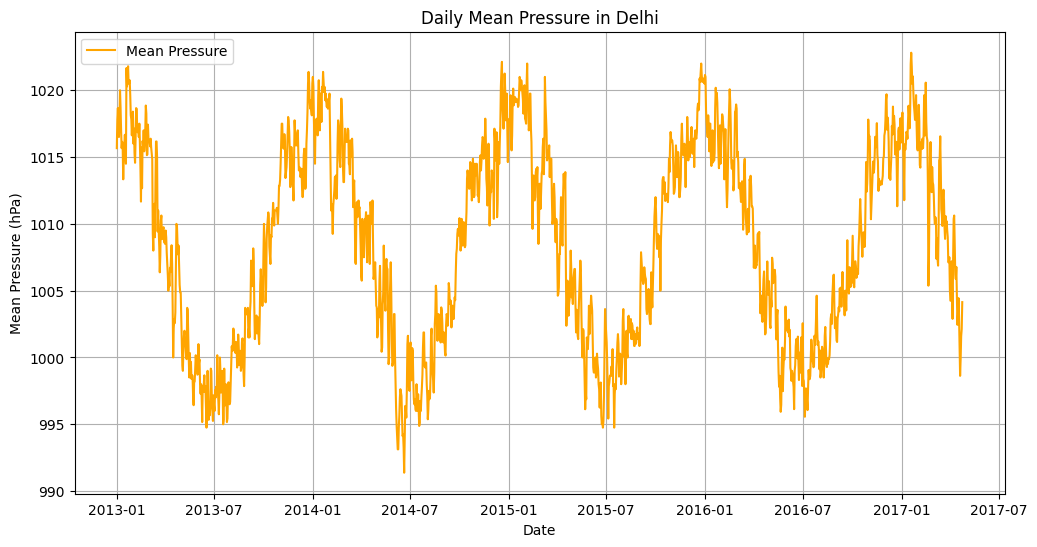

In [34]:
# Remove outliers from the training dataset
filtered_meanpressure = hampel(data['meanpressure'], window_size=10).filtered_data
filtered_meanpressure.index = data.index
data['meanpressure'] = filtered_meanpressure

# Plot the values
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['meanpressure'], color='orange', label='Mean Pressure')
plt.title('Daily Mean Pressure in Delhi')
plt.xlabel('Date')
plt.ylabel('Mean Pressure (hPa)')
plt.legend()
plt.grid(True)
plt.show()

That's much better. Let's print again the summary statistics to confirm that the data is now consistent


In [35]:
print("Summary Statistics:")
data.describe()

Summary Statistics:


,meantemp,humidity,wind_speed,meanpressure
count,1575.000000,1575.000000,1575.000000,1575.000000
mean,25.231582,60.420115,6.903642,1008.571655
std,7.337316,16.956083,4.508803,7.396991
min,6.000000,13.428571,0.000000,991.375000
25%,18.516667,49.750000,3.700000,1001.875000
50%,27.166667,62.380952,6.370000,1009.125000
75%,31.142857,72.125000,9.262500,1015.225006
max,38.714286,98.000000,42.220000,1022.809509


Finally, let's check for potential missing values

In [36]:
# Check for missing values
print("Data missing values:")
print(data.isnull().sum())

Data missing values:
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64


# Understanding Time Series

 A time series is a collection of measurements recorded at specific points in time. We can think of it as a sequence of snapshots capturing how a variable changes over a period.

 In our case we chose to analyze weather data. By observing this data, we can identify some important patterns.

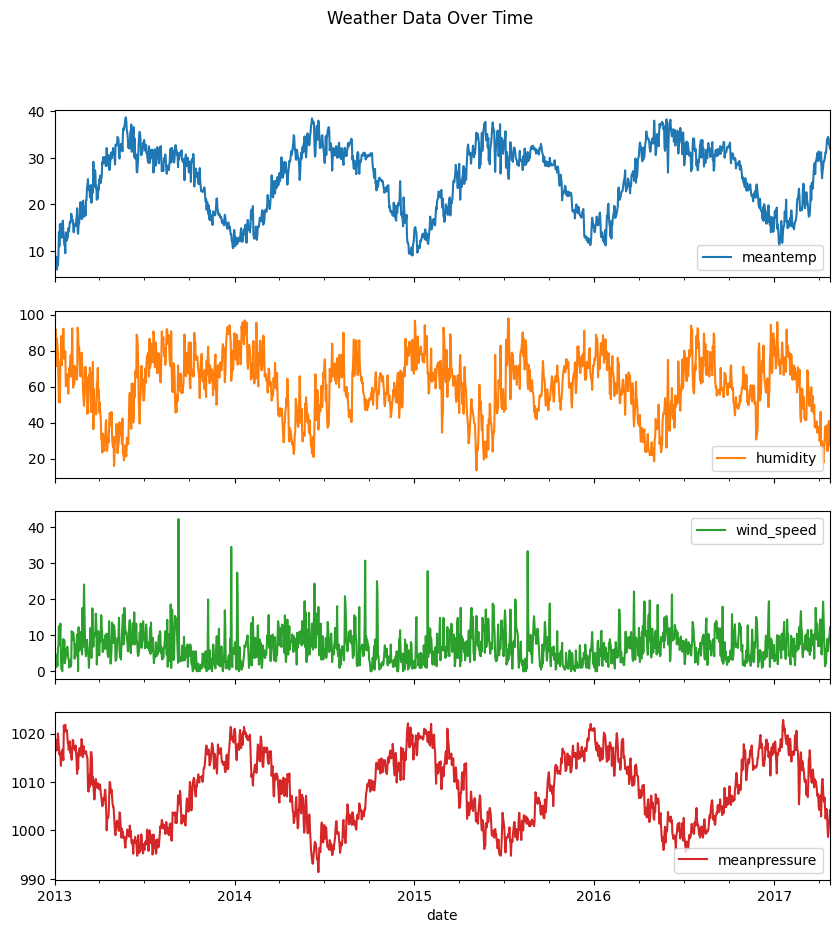

In [37]:
# Visualize all variables in the dataset
data.plot(subplots=True, figsize=(10, 10))
plt.suptitle('Weather Data Over Time')
plt.show()

## Stationarity

In time series forecasting, the concept of stationarity plays an important role, especially for models assuming independence between data points.  Stationary data essentially exhibits a consistent "personality" over time.  Its statistical properties, like mean and variance, remain stable, even if the actual values fluctuate. This characteristic aligns well with the assumption of independence, simplifying the learning process for models like LSTMs.

While LSTMs are known for handling non-stationary data, stationarity can still offer significant advantages. A stable foundation allows the model to focus on identifying the complex relationships that drive accurate predictions. This translates to faster learning and potentially better forecasting performance, particularly with limited datasets. By providing a more consistent learning environment, stationarity empowers LSTMs to  leverage data more effectively, ultimately leading to improved forecasting results.

A well known pattern in weather data is seasonality. Seasonal variation, or seasonality, are cycles that repeat regularly over time. We can easily see these patterns for the temperature and the pressure. We can confirm what we see using the ADF test.

### Check if our time series is stationary

The Augmented Dickey-Fuller (ADF) test is used to determine if a time series is stationary. The null hypothesis of the test states that the series is non-stationary, while the alternative hypothesis states that it is stationary (to understand the concepts of null and alternative hypothesis, see [Statistical hypothesis test](https://en.wikipedia.org/wiki/Statistical_hypothesis_test)). The test provides an ADF Statistic, a p-value, and critical values.

In [38]:
try:
    from statsmodels.tsa.stattools import adfuller
except ImportError:
    %pip install statsmodels
    from statsmodels.tsa.stattools import adfuller

# Function to test stationarity
def test_stationarity(data):
    """Test for stationarity using the Augmented Dickey-Fuller (ADF) test."""
    if isinstance(data, pd.DataFrame):
      for column in data.columns:
          print(f'Testing stationarity for {column}')
          result = adfuller(data[column])
          print(f'ADF Statistic: {result[0]}\np-value: {result[1]}')
          for key, value in result[4].items():
              print(f'Critical Value ({key}): {value}')
          print()
    elif isinstance(data, pd.Series):
      result = adfuller(data)
      print(f'ADF Statistic: {result[0]}\np-value: {result[1]}')
      for key, value in result[4].items():
          print(f'Critical Value ({key}): {value}')
      print()

# Apply the test to all variables
test_stationarity(data)

Testing stationarity for meantemp
ADF Statistic: -2.3753153165816987
p-value: 0.14882501564040634
Critical Value (1%): -3.4345380212339838
Critical Value (5%): -2.8633897592903237
Critical Value (10%): -2.5677547800740443

Testing stationarity for humidity
ADF Statistic: -3.638618158315018
p-value: 0.005064231001719842
Critical Value (1%): -3.4345514752023365
Critical Value (5%): -2.863395697445539
Critical Value (10%): -2.567757942139848

Testing stationarity for wind_speed
ADF Statistic: -4.0067094766113565
p-value: 0.0013757830979996477
Critical Value (1%): -3.4345759114452012
Critical Value (5%): -2.8634064827605656
Critical Value (10%): -2.5677636853277837

Testing stationarity for meanpressure
ADF Statistic: -2.291035627959627
p-value: 0.17487546199347154
Critical Value (1%): -3.4345380212339838
Critical Value (5%): -2.8633897592903237
Critical Value (10%): -2.5677547800740443



If the ADF Statistic is a negative number and more negative than the critical values, and if the p-value is less than 0.05, we reject the null hypothesis and conclude that the series is stationary.

By observing the test output, we can confirm that the temperature and pressure aren't stationary.

### Address non-stationarity
To address the seasonality and non-stationarity present in our temperature and pressure variables, there are multiple methods. A common approach is differencing, which involves subtracting the previous observation from the current one. This process primarily removes trends and seasonal patterns, making the mean of the time series more stable and suitable for modeling. However, differencing introduces a risk: when applying the inverse transformation to recover original values, it can accumulate the errors in the predictions, potentially leading to inaccurate results.

To mitigate this, we can employ seasonal decomposition. This technique breaks down a time series into its core components: trend (long-term increase or decrease), seasonal patterns (e.g., yearly cycles), and random fluctuations (residuals). Separating these elements allows us to add them individually into our dataset and enables our model to identify the correlation between the temperature and the seasons/trends.

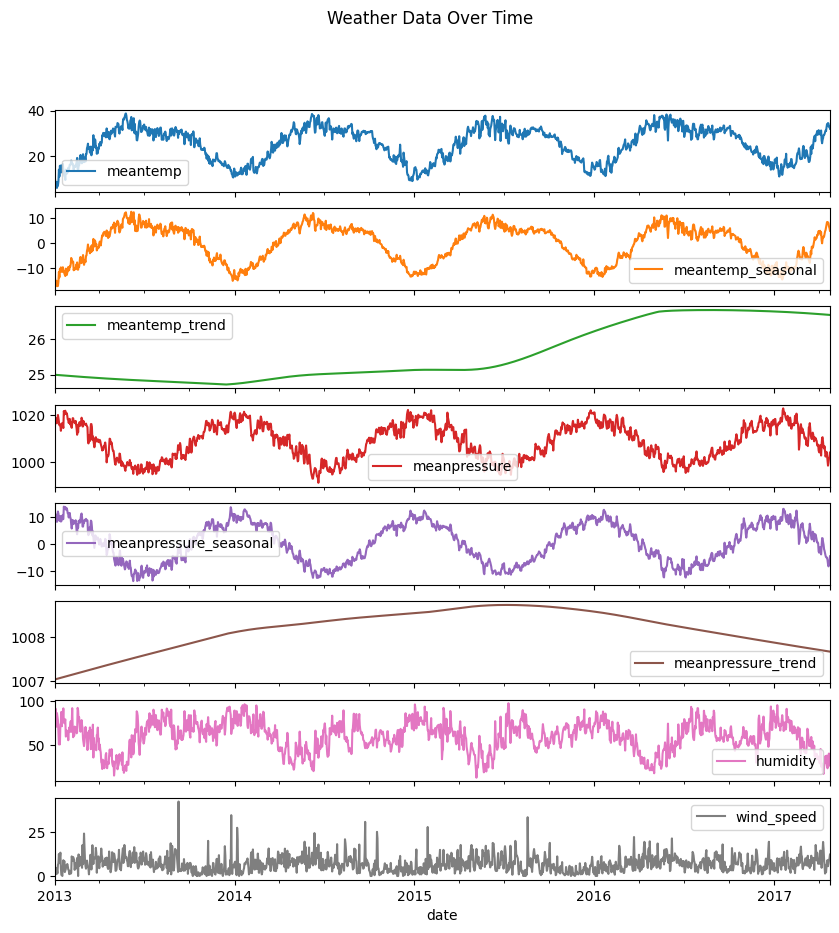

In [39]:
from statsmodels.tsa.seasonal import STL

# Seasonal decomposition to remove trend and seasonality
def seasonal_decompose_series(data, column):
    """Seasonal decomposition of a time series."""
    stl = STL(data[column], period=365)
    res = stl.fit()
    return res.trend, res.seasonal, res.resid

# Apply seasonal decomposition to 'meantemp' and 'meanpressure'
temperature_trend, temperature_seasonal, temperature_residual = seasonal_decompose_series(data, 'meantemp')
pressure_trend, pressure_seasonal, pressure_residual = seasonal_decompose_series(data, 'meanpressure')

# Combine decomposed data
decomposed_data = pd.DataFrame({
    'meantemp': data['meantemp'].values,
    'meantemp_seasonal': temperature_seasonal,
    'meantemp_trend': temperature_trend,
    'meanpressure': data['meanpressure'].values,
    'meanpressure_seasonal': pressure_seasonal,
    'meanpressure_trend': pressure_trend,
    'humidity': data['humidity'].values,
    'wind_speed': data['wind_speed'].values
}, index=data.index)

# Plot
decomposed_data.plot(subplots=True, figsize=(10, 10))
plt.suptitle('Weather Data Over Time')
plt.show()



In [40]:
# Print data
print("Decomposed data:")
print(decomposed_data)

Decomposed data:
             meantemp  meantemp_seasonal  meantemp_trend  meanpressure  \
date                                                                     
2013-01-01  10.000000         -13.724046       24.995840   1015.666687   
2013-01-02   7.400000         -16.422997       24.994732   1017.799988   
2013-01-03   7.166667         -16.178300       24.993627   1018.666687   
2013-01-04   8.666667         -15.119284       24.992523   1017.166687   
2013-01-05   6.000000         -17.283660       24.991420   1016.500000   
...               ...                ...             ...           ...   
2017-04-20  34.500000           8.251838       26.670368    998.625000   
2017-04-21  34.250000           7.855107       26.669242    999.875000   
2017-04-22  32.900000           6.574359       26.668112   1001.599976   
2017-04-23  32.875000           5.946575       26.666977   1002.125000   
2017-04-24  32.000000           4.878028       26.665838   1004.142883   

            meanpres

## Univariate vs. Multivariate Time Series
In time series analysis, data can be either univariate or multivariate. A univariate time series consists of single-variable observations recorded sequentially over time, such as just the temperature. Conversely, a multivariate time series involves multiple variables observed over time, like temperature, humidity, wind speed, and pressure simultaneously.

In the context of our LSTM model for temperature forecasting, using a univariate time series would mean predicting future temperatures based solely on past temperature data. However, leveraging a multivariate approach allows the model to consider additional contextual information, potentially improving its predictive accuracy by accounting for the influence of other related factors.

For the rest of this notebook, we'll consider as univariate data the temperature with its seasonal characteristics, and as multivariate data, all the weather characteristics.


In [41]:
# Create a univariate dataset
univariate_data = decomposed_data[['meantemp', 'meantemp_seasonal', 'meantemp_trend']].astype('float32')

# Create a multivariate dataset
multivariate_data = decomposed_data[['meantemp', 'meantemp_seasonal', 'meantemp_trend', 'meanpressure', 'meanpressure_seasonal', 'meanpressure_trend', 'humidity', 'wind_speed']].astype('float32')


# Understanding LSTM



## Introduction
Long Short-Term Memory (LSTM) networks are a type of Recurrent Neural Network (RNN) (which allow processing sequential data by maintaining a memory of previous inputs) designed to overcome the limitations of basic RNNs, particularly the exploding and vanishing gradient problems. These problems make it difficult to train basic RNNs on long sequences of data because the gradients either grow too large (explode) or become too small (vanish), disrupting the learning process.

## The Core Idea
The main innovation of LSTMs is the use of separate paths for long-term and short-term memories, allowing the network to handle dependencies over different time scales more effectively. Unlike basic RNNs that use a single feedback loop for all memories, LSTMs have mechanisms to control the flow of information.

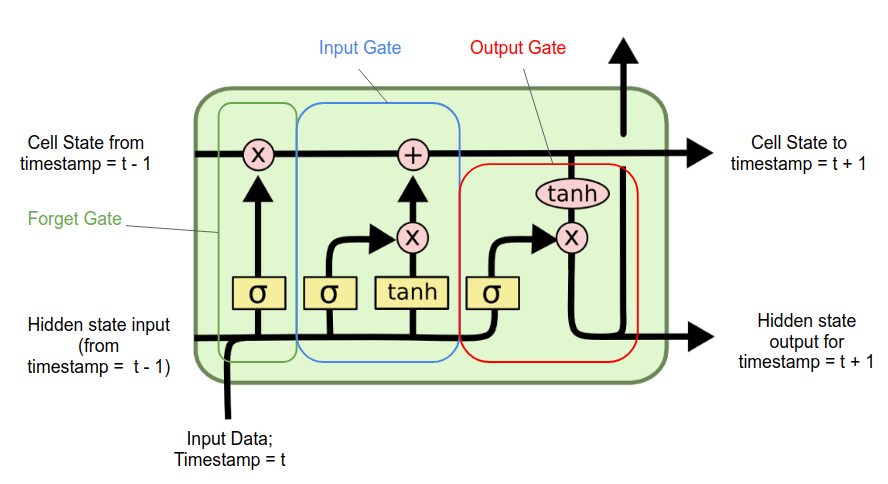

Source: [Medium](https://medium.com/analytics-vidhya/lstms-explained-a-complete-technically-accurate-conceptual-guide-with-keras-2a650327e8f2)

## Key Components
1. **Cell State**: Represents the long-term memory. It flows through the network with minimal modifications, preventing the gradient from exploding or vanishing.
2. **Hidden State**: Represents the short-term memory. It interacts with weights and biases, allowing the network to modify it directly.





## Activation Functions
LSTMs use two types of activation functions:
- **Sigmoid Activation Function**: Maps inputs to values between 0 and 1, determining what percentage of the information to keep or forget.
- **Tanh Activation Function**: Maps inputs to values between -1 and 1, useful for representing the potential memory updates.

## The Three Gates in LSTMs
1. **Forget Gate**: Determines what percentage of the long-term memory to retain. It uses the sigmoid activation function to produce a value between 0 (completely forget) and 1 (fully retain).
   
   Example: If the input is large and negative, the output of the sigmoid function will be close to 0, leading to the long-term memory being mostly forgotten.

2. **Input Gate**: Decides how much of the new information (potential memory) to add to the long-term memory. This involves a combination of the current input and the short-term memory, processed through the tanh activation function, and the percentage to keep, determined by another sigmoid function.

   Example: If the input is positive, the tanh function outputs a value close to 1, and if the sigmoid function's output is also 1, the new information is fully added to the long-term memory.

3. **Output Gate**: Updates the short-term memory based on the new long-term memory. The new long-term memory is processed through the tanh activation function to produce a potential short-term memory, which is then scaled by a sigmoid function output to determine the final short-term memory.

   Example: The tanh function might output 0.99 from the long-term memory, and if the sigmoid function's output is also 0.99, the final short-term memory will be approximately 0.98.

## Why Use LSTM for Weather Forecasting

Long Short-Term Memory (LSTM) networks are well-suited for weather forecasting due to their ability to capture and learn complex temporal dependencies in data. Unlike traditional feedforward neural networks, LSTMs are designed to process and predict sequences of data over time, making them ideal for handling the sequential nature of weather data.

# Model Creation and Training

## Data preprocessing
The process involves several steps, including normalization, and creating sequences of data suitable for the LSTM input.

### Splitting Data into Training and Testing Sets


Let's use 60% of the data for training, and then divide the rest for validation and testing.

In [42]:
# Calculate split points
total_days = len(univariate_data)
TRAIN_END_DATE = int(total_days * 0.6)
VALIDATION_END_DATE = int(total_days * 0.8)


# Split the data into train, validation, and test sets
train_data_univariate = univariate_data[:TRAIN_END_DATE]
validation_data_univariate = univariate_data[TRAIN_END_DATE:VALIDATION_END_DATE]
test_data_univariate = univariate_data[VALIDATION_END_DATE:]

train_data_multivariate = multivariate_data[:TRAIN_END_DATE]
validation_data_multivariate = multivariate_data[TRAIN_END_DATE:VALIDATION_END_DATE]
test_data_multivariate = multivariate_data[VALIDATION_END_DATE:]

print("Train data univariate shape:", train_data_univariate.shape)
print("Validation data univariate shape:", validation_data_univariate.shape)
print("Test data univariate shape:", test_data_univariate.shape)

print("Train data multivariate shape:", train_data_multivariate.shape)
print("Validation data multivariate shape:", validation_data_multivariate.shape)
print("Test data multivariate shape:", test_data_multivariate.shape)



Train data univariate shape: (945, 3)
Validation data univariate shape: (315, 3)
Test data univariate shape: (315, 3)
Train data multivariate shape: (945, 8)
Validation data multivariate shape: (315, 8)
Test data multivariate shape: (315, 8)


### Normalization
Normalization is important as it helps in faster convergence during training and ensures that the model learns effectively. The goal of normalization is to transform features to be on a similar scale (in our case, between 0 and 1). This improves the performance and training stability of the model.

In [43]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def scale_data(data):
    """Scale each column of the data"""
    scaler_dict = {}
    for col in data.columns:
        scaler = MinMaxScaler(feature_range=(0, 1))
        data.loc[:, col] = scaler.fit_transform(data.loc[:, [col]])
        scaler_dict[col] = scaler
    return data, scaler_dict

# Normalize the data
uni_train_scaled, uni_train_scalers = scale_data(train_data_univariate)
uni_validation_scaled, uni_validation_scalers = scale_data(validation_data_univariate)
uni_test_scaled, uni_test_scalers = scale_data(test_data_univariate)

multi_train_scaled, multi_train_scalers = scale_data(train_data_multivariate)
multi_validation_scaled, multi_validation_scalers = scale_data(validation_data_multivariate)
multi_test_scaled, multi_test_scalers = scale_data(test_data_multivariate)

/tmp/ipykernel_17497/1590373404.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[[0.12227073]
 [0.04279476]
 [0.03566229]
 [0.08151382]
 [0.        ]
 [0.03056768]
 [0.03056768]
 [0.08733621]
 [0.24454147]
 [0.15283841]
 [0.29694322]
 [0.24454147]
 [0.30058223]
 [0.20887917]
 [0.26637554]
 [0.23944685]
 [0.3209607 ]
 [0.23944685]
 [0.19868994]
 [0.16157204]
 [0.15895197]
 [0.10698688]
 [0.24454147]
 [0.23944685]
 [0.19104803]
 [0.20378458]
 [0.20960698]
 [0.27001452]
 [0.24836245]
 [0.26637554]
 [0.3117904 ]
 [0.30567685]
 [0.3144105 ]
 [0.36681223]
 [0.34934497]
 [0.32478166]
 [0.3260553 ]
 [0.2934498 ]
 [0.24454147]
 [0.28820962]
 [0.28275108]
 [0.3018559 ]
 [0.28529838]
 [0.3144105 ]
 [0.34643376]
 [0.40247452]
 [0.2576419 ]
 [0.23435226]
 [0.2934498 ]
 [0.30131003]
 [0.35807854]
 [0.42794758]
 [0.4432314 ]
 [0.34934497]
 [0.3318777 ]
 [0.33242357]
 [0.3624454 ]
 [0.4524017 ]
 [0.41048032]
 [0.34643376]
 [0.

### Creating Sequences
LSTM models require input data to be in the form of sequences. We need to create sequences of a fixed length from our normalized data. For each sequence X, the corresponding target Y value will be the next value in the time series (single-step forecast).

In [44]:
def create_single_step_sequences(data, target_col, seq_length):
    """Create sequences for the given data and target."""
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data.iloc[i:i+seq_length,:].values
        y = data.iloc[i+seq_length, target_col]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Define sequence length, we use T past values to predict the next value
T = 20

# Create sequences for univariate data
x_train_uni, y_train_uni = create_single_step_sequences(uni_train_scaled, 0, T)
x_val_uni, y_val_uni = create_single_step_sequences(uni_validation_scaled, 0, T)
x_test_uni, y_test_uni = create_single_step_sequences(uni_test_scaled, 0, T)

# Create sequences for multivariate data
x_train_multi, y_train_multi = create_single_step_sequences(multi_train_scaled, 0, T)
x_val_multi, y_val_multi = create_single_step_sequences(multi_validation_scaled, 0, T)
x_test_multi, y_test_multi = create_single_step_sequences(multi_test_scaled, 0, T)

# Make sure that the shape is : n_samples, time_steps, n_feature
print("x_train_uni shape:", x_train_uni.shape)
print("y_train_uni shape:", y_train_uni.shape)
print("x_val_uni shape:", x_val_uni.shape)
print("y_val_uni shape:", y_val_uni.shape)
print("x_test_uni shape:", x_test_uni.shape)
print("y_test_uni shape:", y_test_uni.shape)

print("x_train_multi shape:", x_train_multi.shape)
print("y_train_multi shape:", y_train_multi.shape)
print("x_val_multi shape:", x_val_multi.shape)
print("y_val_multi shape:", y_val_multi.shape)
print("x_test_multi shape:", x_test_multi.shape)
print("y_test_multi shape:", y_test_multi.shape)


x_train_uni shape: (925, 20, 3)
y_train_uni shape: (925,)
x_val_uni shape: (295, 20, 3)
y_val_uni shape: (295,)
x_test_uni shape: (295, 20, 3)
y_test_uni shape: (295,)
x_train_multi shape: (925, 20, 8)
y_train_multi shape: (925,)
x_val_multi shape: (295, 20, 8)
y_val_multi shape: (295,)
x_test_multi shape: (295, 20, 8)
y_test_multi shape: (295,)


## Single-step forecast
In time series forecasting, a single-step forecast refers to predicting the value of the next time step, based on the available historical data. This approach is particularly useful when the primary goal is to anticipate short-term trends or immediate changes in the data, such as predicting the temperature for the next day.

### Build the model

We are going to start with a simple LSTM architecture composed of one LSTM layer as input and a Dense layer which will output the prediction.
We'll train both a univariate and multivariate model, with the only difference being the input shape.

In [45]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
import tensorflow as tf

# Set the random seed for reproducibility
tf.keras.utils.set_random_seed(100)
tf.config.experimental.enable_op_determinism()


def build_and_train_model(x_train, y_train, x_val_uni, y_val_uni, epochs=100, batch_size=64):
    """Build and train the model."""
    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(units=50, return_sequences = False, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer='adam', loss= 'mse' , metrics=['mean_absolute_error'])

    # print summary
    model.summary()

    # Train the model
    history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_val_uni, y_val_uni))

    return model, history

### Univariate model
Let's start by training our univariate model and see how well it learns and perform on new data

#### Train the model

In [19]:
# Build and train the model
model_uni, history_uni = build_and_train_model(x_train_uni, y_train_uni, x_val_uni, y_val_uni)

/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,851 (42.39 KB)

 Trainable params: 10,851 (42.39 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.1687 - mean_absolute_error: 0.3411 - val_loss: 0.0188 - val_mean_absolute_error: 0.1132
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0102 - mean_absolute_error: 0.0807 - val_loss: 0.0148 - val_mean_absolute_error: 0.0977
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0068 - mean_absolute_error: 0.0659 - val_loss: 0.0097 - val_mean_absolute_error: 0.0804
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0051 - mean_absolute_error: 0.0571 - val_loss: 0.0100 - val_mean_absolute_error: 0.0819
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0048 - mean_absolute_error: 0.0550 - val_loss: 0.0091 - val_mean_absolute_error: 0.0784
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0046 - mean_absolute_error: 0.0534 - val_loss: 0.0088 - val_mean_absolute_error: 0.0772
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0045 - mean_absolute_error: 0.0527 - val_los

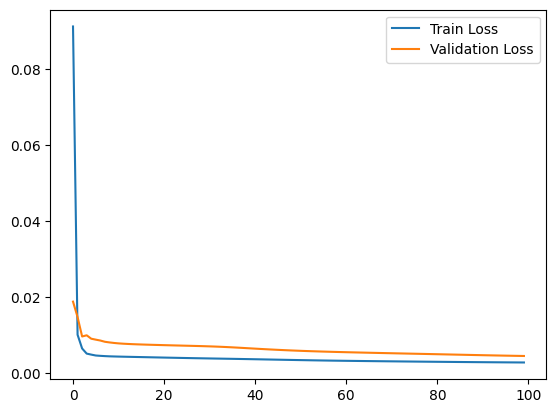

In [20]:
# Plot train and validation loss
plt.plot(history_uni.history['loss'], label='Train Loss')
plt.plot(history_uni.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

We can see that our model learns rapidly. The train loss flattens out around .003 and the validation loss converges towards our train loss which is encouraging.

Let's now see how it performs on new data

#### Test the model

In [21]:
def evaluate_model(model, x_test, y_test):
    """Evaluate the model and return the loss, MAE, and predictions."""
    loss, mae = model.evaluate(x_test, y_test)
    predictions = model.predict(x_test)
    return loss, mae, predictions

def reconstruct_data(predictions, y_test, scaler):
    """Reconstruct the original values by reverting scale and adding the seasonal component."""
    # Reshape predictions
    predictions_reshaped = predictions.reshape(-1, 1)
    y_test_reshaped = y_test.reshape(-1, 1)

    # Revert scale
    predictions_rescaled = scaler.inverse_transform(predictions_reshaped)
    y_test_rescaled = scaler.inverse_transform(y_test_reshaped)

    return y_test_rescaled, predictions_rescaled

def plot_results(index, true_values, predictions, title):
    """Plot the true values and predictions."""
    plt.figure(figsize=(12, 8))
    plt.plot(index, true_values, label='True Values')
    plt.plot(index, predictions, label='Predictions')
    plt.legend()
    plt.title(title)
    plt.show()


# Evaluate the univariate model
loss_uni, mae_uni, predictions_uni = evaluate_model(model_uni, x_test_uni, y_test_uni)

# Reconstruct the univariate data
y_test_uni_reconstructed, predictions_uni_reconstructed = reconstruct_data(predictions_uni, y_test_uni, uni_test_scalers['meantemp'])


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0041 - mean_absolute_error: 0.0512 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [22]:
# Print metrics
print("Loss:", loss_uni)
print("MAE:", mae_uni)


Loss: 0.004051387310028076
MAE: 0.05109863355755806


The loss and MAE seem to be close but a little be higher that the values obtained during training.

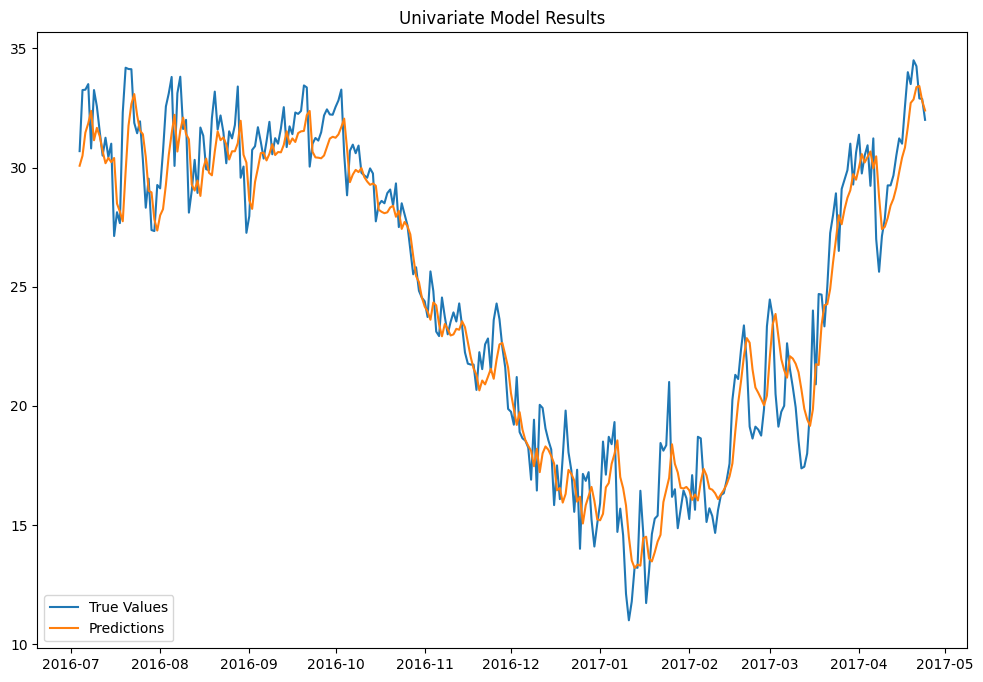

In [23]:
# Plot the univariate results
plot_results(decomposed_data.index[-len(y_test_uni_reconstructed):], y_test_uni_reconstructed, predictions_uni_reconstructed, 'Univariate Model Results')

The model captures the overall trend in the data fairly well. Both the true values and predictions show similar upward and downward trends over the given period.

There are some discrepancies between the true values and the predictions, particularly in the amplitude of the variations. The predictions tend to be slightly smoother than the true values, which may suggest that the model is not capturing all the short-term fluctuations accurately.

### Multivariate model
Before trying to build a more complex model, we can see if adding the pressure, humidity and wind speed will help our model

#### Train the model

In [24]:
# Build and train the multivariate model
model_multi, history_multi = build_and_train_model(x_train_multi, y_train_multi, x_val_multi, y_val_multi)

/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 50)             │        11,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,851 (46.29 KB)

 Trainable params: 11,851 (46.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.2615 - mean_absolute_error: 0.4335 - val_loss: 0.0755 - val_mean_absolute_error: 0.2218
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0234 - mean_absolute_error: 0.1239 - val_loss: 0.0077 - val_mean_absolute_error: 0.0660
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0074 - mean_absolute_error: 0.0672 - val_loss: 0.0067 - val_mean_absolute_error: 0.0621
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0055 - mean_absolute_error: 0.0590 - val_loss: 0.0083 - val_mean_absolute_error: 0.0685
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0045 - mean_absolute_error: 0.0526 - val_loss: 0.0063 - val_mean_absolute_error: 0.0589
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0042 - mean_absolute_error: 0.0509 - val_loss: 0.0061 - val_mean_absolute_error: 0.0582
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0041 - mean_absolute_error: 0.0505 - val_loss: 0.0060 - 

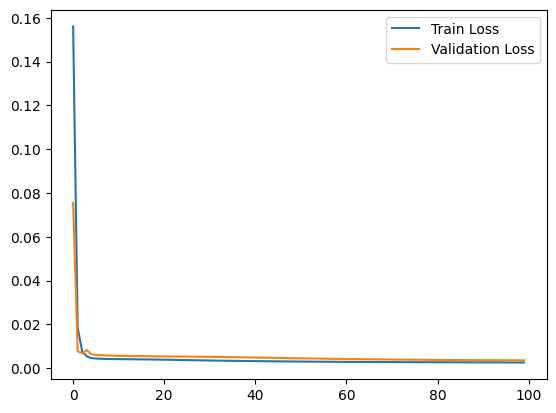

In [25]:
# Plot loss
plt.plot(history_multi.history['loss'], label='Train Loss')
plt.plot(history_multi.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [26]:
# Evaluate the multivariate model
loss_multi, mae_multi, predictions_multi = evaluate_model(model_multi, x_test_multi, y_test_multi)

# Reconstruct the multivariate data
y_test_multi_reconstructed, predictions_multi_reconstructed = reconstruct_data(predictions_multi, y_test_multi, multi_test_scalers['meantemp'])

# Print metrics
print("Loss:", loss_multi)
print("MAE:", mae_multi)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0044 - mean_absolute_error: 0.0515 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Loss: 0.005281144753098488
MAE: 0.056406550109386444


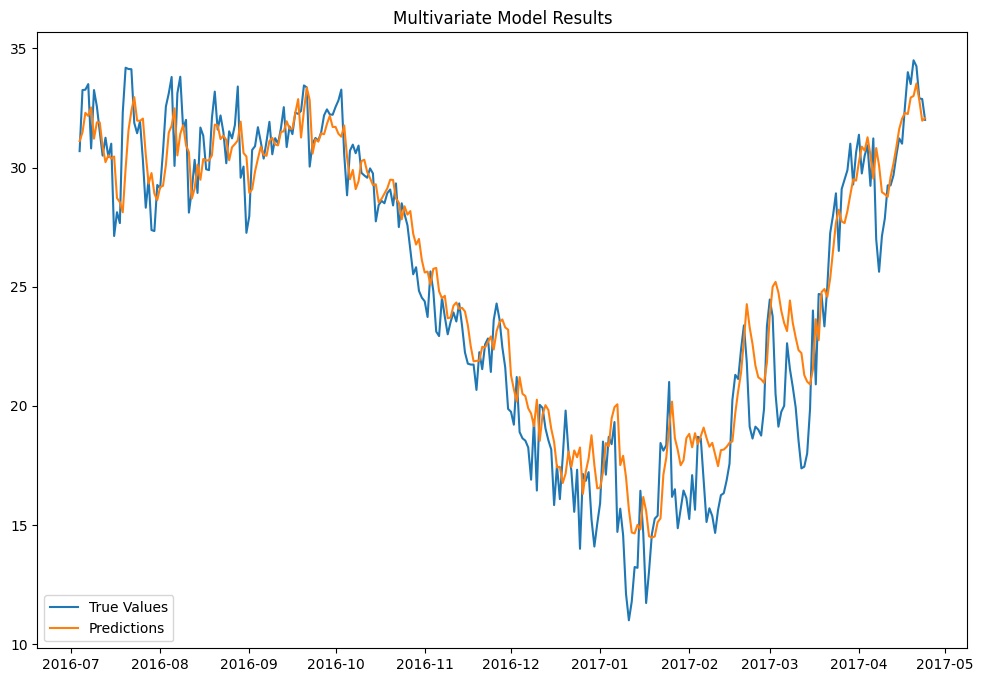

In [27]:
# Plot the multivariate results
plot_results(decomposed_data.index[-len(y_test_multi_reconstructed):], y_test_multi_reconstructed, predictions_multi_reconstructed, 'Multivariate Model Results')

We can compare the results of the two models by plotting on the same figure

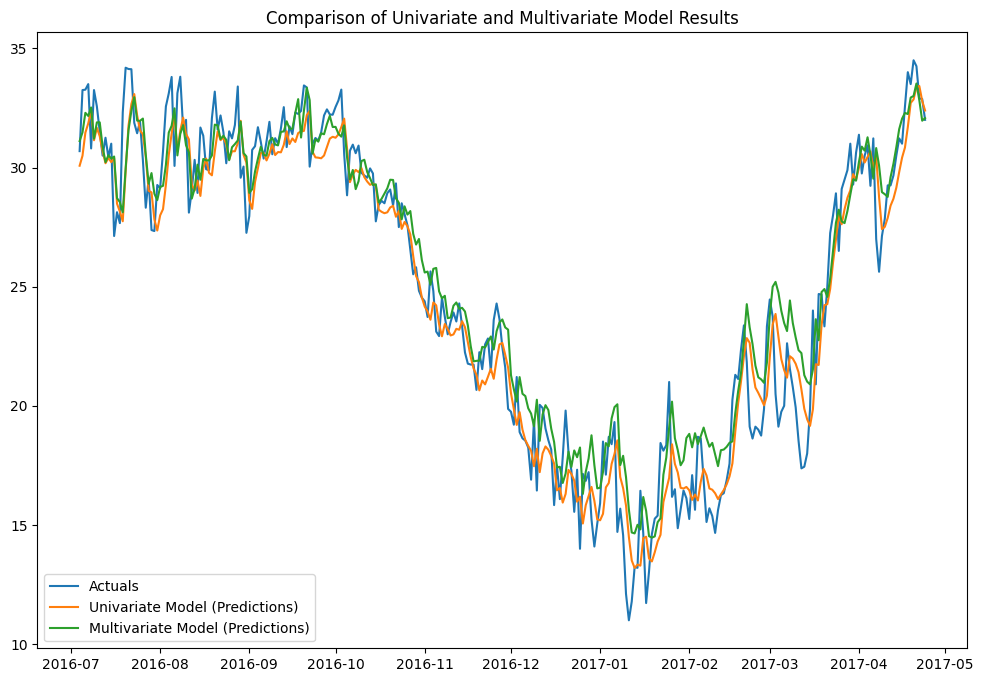

In [46]:
# Plot the predictions of the two models and the actuals
plt.figure(figsize=(12, 8))
plt.plot(decomposed_data.index[-len(y_test_uni_reconstructed):], y_test_uni_reconstructed, label='Actuals')
plt.plot(decomposed_data.index[-len(y_test_uni_reconstructed):], predictions_uni_reconstructed, label='Univariate Model (Predictions)')
plt.plot(decomposed_data.index[-len(y_test_multi_reconstructed):], predictions_multi_reconstructed, label='Multivariate Model (Predictions)')
plt.legend()
plt.title('Comparison of Univariate and Multivariate Model Results')
plt.show()